In [1]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import pandas as pd

In [2]:
bd.projects.set_current("fresh-start")

In [3]:
for db_name in list(bd.databases):
    del bd.databases[db_name]

In [8]:
db = bd.Database("mobility")
db.register()

biosphere = bd.Database("biosphere")
biosphere.register()

In [11]:
data = {
    'code': 'bike',
    'name': 'bike production',
    'location': 'NO',
    'unit': 'bike'
}

bike = db.new_activity(**data)
bike.save()

In [12]:
data = {
    'code': 'CF',
    'name': 'carbon fibre',
    'unit': 'kilogram',
    'location': 'CN'
}

cf = db.new_activity(**data)
cf.save()

In [13]:
ng = db.new_node(
    name="Nat Gas", 
    code='ng', 
    location='NO', 
    unit='MJ'
)

ng.save()

In [14]:
co2 = biosphere.new_node(
    name="Carbon Dioxide", 
    code='co2', 
    categories=('air',),
    type='emission',
)

co2.save()

In [15]:
bike.new_edge(
    amount=2.5, 
    type='technosphere',
    input=cf
).save()

In [16]:
cf.new_edge(
    amount=237.3,  # plus 58 kWh of electricity, in ecoinvent 3.8 
    uncertainty_type=5, 
    minimum=200, 
    maximum=300, 
    type='technosphere',
    input=ng,
).save()

In [17]:
cf.new_edge(
    amount=26.6, 
    uncertainty_type=5, 
    minimum=26,
    maximum=27.2, 
    type='biosphere',
    input=co2,
).save()

In [18]:
ipcc = bd.Method(('IPCC',))
ipcc.write([
    (co2.key, {'amount': 1, 'uncertainty_type': 3, 'loc': 1, 'scale': 0.05}),
])

In [19]:
import bw2calc as bc

In [20]:
for obj in bd.Database("mobility"):
    print(obj.id, obj)

3 'Nat Gas' (MJ, NO, None)
2 'carbon fibre' (kilogram, CN, None)
1 'bike production' (bike, NO, None)


In [21]:
bike = bd.get_activity(1)

In [23]:
lca = bc.LCA(
    {bike: 1}, # Func unit is one bike
    ('IPCC',),
    use_distributions=True,
    seed_override=None
)
lca.lci()
lca.lcia()

In [24]:
lca.technosphere_matrix.toarray()

array([[   1.        ,    0.        ,    0.        ],
       [  -2.5       ,    1.        ,    0.        ],
       [   0.        , -243.20599945,    1.        ]])

In [25]:
lca.biosphere_matrix.toarray()

array([[ 0.        , 26.75185723,  0.        ]])

In [26]:
lca.characterization_matrix.toarray()

array([[0.97608829]])

In [126]:
lca.demand_array

array([1., 0., 0.])

In [115]:
list(lca.dicts.product.items())

[(2654, 0), (2655, 1), (2656, 2)]

In [116]:
list(lca.dicts.activity.items())

[(2654, 0), (2655, 1), (2656, 2)]

In [117]:
lca.build_demand_array({2655: 4444})

In [106]:
bd.Database("mobility").process()

In [89]:
df = pd.DataFrame([
    {
        'score': lca.score, 
        'inv': lca.inventory.sum(), 
        # 'heat': lca.technosphere_matrix[lca.dicts.product[ng.id], lca.dicts.activity[cf.id]],
        'char': lca.characterization_matrix.sum()
    } for _, _ in zip(lca, range(100))
])
df

,score,inv,char
0,0.113052,0.105623,1.070339
1,0.119319,0.115367,1.034255
2,0.104629,0.109372,0.956640
3,0.104460,0.106282,0.982862
4,0.120127,0.117405,1.023182
...,...,...,...
95,0.116019,0.113474,1.022429
96,0.110372,0.112573,0.980449
97,0.120151,0.116115,1.034754
98,0.104303,0.110353,0.945177


array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

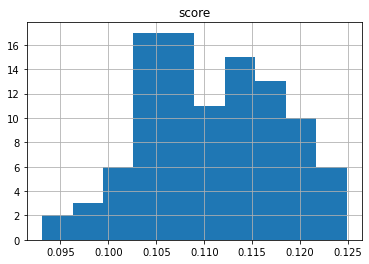

In [90]:
df.hist('score')

What if we only want uncertainty in the characterization step?

We need to modify the datapackage a bit

In [44]:
from bw_processing import load_datapackage
from fs.zipfs import ZipFS

In [128]:
database_dp = load_datapackage(ZipFS(db.filepath_processed()))
method_dp = load_datapackage(ZipFS(ipcc.filepath_processed()))

We can use the datapackages directly, just as before:

In [129]:
bike.id

2655

In [132]:
bd.get_id(bike)

2654

In [133]:
bike.id

2655

In [130]:
lca = bc.LCA(
    demand={2655: 1},
    data_objs=[database_dp, method_dp],
    use_distributions=True,
    seed_override=None
)
lca.lci()
lca.lcia()

In [131]:
pd.DataFrame([
    {
        'score': lca.score, 
        'inv': lca.inventory.sum(), 
        'char': lca.characterization_matrix.sum()
    } for _, _ in zip(lca, range(10))
])

,score,inv,char
0,73.069695,68.923760,1.060152
1,63.054393,61.502302,1.025236
2,66.257254,72.299744,0.916424
3,58.039134,65.926548,0.880361
4,60.621198,63.837397,0.949619
5,79.369478,72.580892,1.093531
6,58.728043,61.843008,0.949631
7,74.633912,73.111030,1.020830
8,78.986730,85.264106,0.926377
9,73.959913,74.334350,0.994963


But we can also filter out the uncertainty from the $A$ matrix:

In [54]:
database_dp.groups

{'mobility_biosphere_matrix': <bw_processing.datapackage.FilteredDatapackage at 0x127e50fa0>,
 'mobility_inventory_geomapping_matrix': <bw_processing.datapackage.FilteredDatapackage at 0x127e50e20>,
 'mobility_technosphere_matrix': <bw_processing.datapackage.FilteredDatapackage at 0x127e50df0>}

In [59]:
database_dp.get_resource('mobility_technosphere_matrix.distributions')

(array([(0,   1. , nan, nan,  nan,  nan, False),
        (0,   2.5, nan, nan,  nan,  nan, False),
        (0,   1. , nan, nan,  nan,  nan, False),
        (5, 237.3, nan, nan, 200., 300., False),
        (0,   1. , nan, nan,  nan,  nan, False)],
       dtype=[('uncertainty_type', 'u1'), ('loc', '<f4'), ('scale', '<f4'), ('shape', '<f4'), ('minimum', '<f4'), ('maximum', '<f4'), ('negative', '?')]),
 {'profile': 'data-resource',
  'format': 'npy',
  'mediatype': 'application/octet-stream',
  'name': 'mobility_technosphere_matrix.distributions',
  'matrix': 'technosphere_matrix',
  'kind': 'distributions',
  'path': 'mobility_technosphere_matrix.distributions.npy',
  'group': 'mobility_technosphere_matrix',
  'nrows': 5,
  'category': 'vector'})

In [55]:
filtered_dp = (database_dp
               .exclude_resource_group_kind('mobility_technosphere_matrix', 'distributions')
               .exclude_resource_group_kind('mobility_biosphere_matrix', 'distributions')
              )

In [56]:
[obj['name'] for obj in database_dp.resources if obj['kind'] == 'distributions']

['mobility_biosphere_matrix.distributions',
 'mobility_technosphere_matrix.distributions']

In [57]:
[obj['name'] for obj in filtered_dp.resources if obj['kind'] == 'distributions']

[]

In [60]:
lca = bc.LCA(
    {bike.id: 1},
    data_objs=[filtered_dp, method_dp],
    use_distributions=True,
    seed_override=None
)
lca.lci()
lca.lcia()

In [61]:
pd.DataFrame([
    {
        'score': lca.score, 
        'inv': lca.inventory.sum(), 
        'char': lca.characterization_matrix.sum()
    } for _, _ in zip(lca, range(10))
])

,score,inv,char
0,66.725181,66.500001,1.003386
1,65.101532,66.500001,0.978970
2,65.754924,66.500001,0.988796
3,67.342051,66.500001,1.012662
4,64.211793,66.500001,0.965591
5,69.542878,66.500001,1.045758
6,65.772137,66.500001,0.989055
7,68.447438,66.500001,1.029285
8,67.715640,66.500001,1.018280
9,70.597701,66.500001,1.061620


We have a problem in our modelling. Maybe you spotted it already; in any case, we can see this LCI data in a document. This is the third perspective, and so we need to use our third library: `bw2io`.

In [62]:
from bw2io.export import write_lci_excel

In [63]:
from pathlib import Path

In [64]:
xl = Path(write_lci_excel(db.name))

In [65]:
xl.rename(Path.cwd() / xl.name)

PosixPath('/Users/cmutel/Code/brightway/from-the-ground-up/notebooks/lci-mobility.xlsx')

In [101]:
bi.create_core_migrations()

In [67]:
xl_importer.strategies

[<function bw2io.strategies.csv.csv_restore_tuples(data)>,
 <function bw2io.strategies.csv.csv_restore_booleans(data)>,
 <function bw2io.strategies.csv.csv_numerize(data)>,
 <function bw2io.strategies.csv.csv_drop_unknown(data)>,
 <function bw2io.strategies.csv.csv_add_missing_exchanges_section(data)>,
 <function bw2io.strategies.generic.normalize_units(db)>,
 <function bw2io.strategies.biosphere.normalize_biosphere_categories(db, lcia=False)>,
 <function bw2io.strategies.biosphere.normalize_biosphere_names(db, lcia=False)>,
 <function bw2io.strategies.biosphere.strip_biosphere_exc_locations(db)>,
 <function bw2io.strategies.generic.set_code_by_activity_hash(db, overwrite=False)>,
 functools.partial(<function link_iterable_by_fields at 0x122ed8c10>, other=Brightway2 SQLiteBackend: biosphere3, kind='biosphere'),
 <function bw2io.strategies.generic.assign_only_product_as_production(db)>,
 <function bw2io.strategies.generic.link_technosphere_by_activity_hash(db, external_db_name=None, fie

In [79]:
xl_importer = bi.ExcelImporter("lci-mobility.xlsx")

Extracted 1 worksheets in 0.03 seconds


In [80]:
xl_importer.apply_strategies()

Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.03 seconds


In [81]:
xl_importer.statistics()

3 datasets
3 exchanges
1 unlinked exchanges
  Type biosphere: 1 unique unlinked exchanges


(3, 3, 1)

In [83]:
for obj in xl_importer.unlinked:
    print(obj)

{'name': 'Carbon Dioxide', 'amount': 0.11209439528023599, 'categories': ('air',), 'type': 'biosphere', 'minimum': 0.1, 'maximum': 0.12, 'uncertainty_type': 5}


In [84]:
co2['name'] == obj['name']

True

In [85]:
xl_importer.match_database("biosphere", fields=['name'])

Applying strategy: link_iterable_by_fields


In [86]:
xl_importer.all_linked

3 datasets
3 exchanges
0 unlinked exchanges
  


True

In [87]:
xl_importer.write_database()

Writing activities to SQLite3 database:
0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 10/19/2021 11:00:37
  Finished: 10/19/2021 11:00:37
  Total time elapsed: 00:00:00
  CPU %: 48.10
  Memory %: 1.21
Created database: mobility
